In [1]:
%load_ext autotime

In [2]:
# Importar librerias
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


import numpy as np

import zipfile
from datetime import date
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import classification_report


from hyperopt import hp, fmin, tpe, hp, STATUS_OK, Trials

from numpy.testing import assert_allclose

import tensorflow as tf

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dropout, Dense, GlobalMaxPool1D, Conv1D, Flatten,  MaxPooling1D, Activation, GlobalMaxPooling1D, Bidirectional, GRU
from tensorflow.compat.v1.keras.layers import CuDNNGRU
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adadelta
from sklearn.decomposition import PCA

import os
from pathlib import Path


time: 2.82 s


In [3]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)

time: 2.76 ms


In [4]:
exp_name = '7_C'
folder = 'Resultados/' + exp_name
my_file = Path(folder)
if os.path.exists(my_file):
    print('already exists')
else:
    os.makedirs(folder)
    


already exists
time: 148 ms


In [5]:
ch_folder = folder + '/Checkpoints'
my_file = Path(ch_folder)
if os.path.exists(my_file):
    print('already exists')
else:
    os.makedirs(ch_folder)

already exists
time: 91.7 ms


### Read datasets

In [6]:
#Importar los datasets
url_embeddings_average_individual = zipfile.ZipFile('../Data/sum_topics.zip')

embeddings_average_individual = pd.read_csv(url_embeddings_average_individual.open('sum_topics.csv'))


embeddings_average_individual['Date'] =  pd.to_datetime(embeddings_average_individual['Date'], format='%Y-%m-%d')

embeddings_average_individual.reset_index()
embeddings_average_individual.fillna(0, inplace=True)
embeddings_average_individual.tail(2)
n_pc = 3

time: 4.21 s


In [7]:
#embeddings_average_individual= embeddings_average_individual.drop(list(map(str, range(0, 300))), axis = 1)
 


time: 330 µs


### Embedding Promedio

In [8]:
# Selecciono la fecha para la cual hago el corte de train y test
training_end = pd.to_datetime("2013-12-31")
num_training = len(embeddings_average_individual[(embeddings_average_individual["Date"]) <= training_end])

time: 198 ms


In [9]:
# Selecciono el archivo con el que se corre el modelo
data = embeddings_average_individual[embeddings_average_individual['Date']<='2014-12-31']
print(data['Label'].mean())
data.head(1)

0.5418076004775169


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,Label,Date,Top,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
9443,-0.414062,-0.006348,-0.658142,0.591064,-0.103027,-0.636108,0.143799,-0.545385,0.495117,0.868652,0.374756,-0.693848,-0.126572,-0.297241,-0.302734,0.503906,-0.122284,0.49115,-0.153564,-0.068848,-0.349243,-0.21582,-0.74231,-0.924805,0.099846,-0.367065,-0.512451,0.687988,0.49675,-0.347755,-0.48877,0.314697,-0.244385,-0.281799,-0.506836,0.142334,-0.194809,0.20752,0.243652,0.040039,-0.213608,-0.341537,0.331818,-0.067871,-0.065918,-0.682373,-0.365723,-0.066406,0.358643,0.351807,-0.117188,0.37207,0.265381,-0.429077,-0.137939,-0.450928,0.133118,0.085449,0.156219,-0.109497,0.001923,-0.022705,-0.417908,-0.169189,0.049438,-0.525635,-0.460419,0.049866,0.150635,0.080322,-0.030396,-0.021729,0.157593,-0.223633,-1.036133,-0.653809,0.386719,-0.060547,0.035095,-0.402344,0.231689,-0.289612,0.120026,-0.40918,-0.146851,0.306885,-0.096558,0.358215,0.116455,0.228027,-0.61377,-0.193115,-0.411133,-0.213379,-0.114746,0.188599,0.197998,-0.073486,0.683838,-0.172363,-0.041016,-0.573608,0.504395,0.211914,-0.162354,0.30603,0.001465,0.170898,0.420959,-0.34317,-0.181152,0.071289,-0.48082,0.001099,-0.721191,-0.030029,0.185043,0.528809,0.291992,0.503784,-0.742676,-0.444824,-0.24707,0.33374,-0.035797,-0.171753,-0.677246,-0.61499,0.263672,0.260742,-0.167786,-0.194824,-0.513184,0.361633,0.079102,-0.396118,0.56665,-0.304199,-0.401611,0.452225,-0.276642,-0.838867,-0.537598,0.104797,-0.045776,0.562012,-0.362854,-0.109131,-0.427734,-0.440674,0.237793,0.057251,-0.625,0.299011,-0.286743,-0.726807,0.112427,-0.127563,-0.206787,-0.080811,-0.570801,-0.179321,-0.192383,0.131897,-0.119019,-0.262329,0.565674,-0.371094,-0.144043,-0.60498,-0.501953,-0.079529,0.210938,-0.310852,-0.274902,0.186768,-0.002441,-0.156967,-0.385742,0.306641,0.006348,-0.262329,-0.338379,0.130371,0.160645,0.204346,-0.092529,0.104492,0.511719,-0.153397,0.031677,-0.549194,-0.080078,0.195557,-0.581543,1.931641,-0.022217,0.245361,-0.24292,-1.124756,0.058044,0.23848,-0.640137,-0.992188,0.419434,0.507011,0.213318,0.111694,-0.348694,-0.495483,-0.67981,0.643921,-1.069824,0.618263,-0.6521,-0.007568,0.918945,0.277588,-0.323242,0.42276,-0.108826,-0.62207,0.2258,0.128052,-0.058838,-0.029053,-0.512634,0.399902,0.194336,0.43811,0.553818,-0.179688,-0.586914,-0.579834,0.151703,0.275513,0.43335,0.116516,0.621368,0.091797,0.289185,-0.162201,-0.308594,-0.993164,-0.434937,0.127319,0.22876,-0.136292,0.04541,-0.318115,-0.021729,0.220459,0.481445,0.604004,-0.044678,-1.235352,-0.437988,-0.087646,0.066284,-0.027008,0.597168,0.156006,0.050171,0.951904,-0.282959,0.050781,-0.397812,-0.916504,-0.266693,-0.746643,0.036865,0.55542,-0.49585,0.096924,-0.25354,0.218994,-0.921387,-0.67749,0.320801,0.324951,0.417236,0.280579,0.020386,0.679016,0.473511,-0.006714,-0.256409,0.536255,-0.487305,0.786133,0.134155,-0.624756,0.000488,0.336426,0.259277,-0.118896,0.110352,0.100067,0

time: 283 ms


In [10]:
training = data[:num_training]
testing = data[num_training:]

# Se separa en train y test
x_train = data.drop(["Top","Label", "Date"], axis=1)[:num_training]
x_test = data.drop(["Top",'Label', 'Date'], axis=1)[num_training:]
y_train = data["Label"].values[:num_training]
y_test = data["Label"].values[num_training:]


x_train_array = x_train.to_numpy()
reshape_x_train = x_train_array.reshape(len(x_train), 1, x_train.shape[1])
reshape_x_train.shape

x_test_array = x_test.to_numpy()
reshape_x_test = x_test_array.reshape(len(x_test), 1, x_train.shape[1])
reshape_x_test.shape

(6294, 1, 310)

time: 66.5 ms


In [11]:
# Extract the ideal number of estimators and hyperparameters
best_bayes_params = {'activation': 'softmax',
 'batch_size': 512,
 'dropout1': 0.3,
 'dropout2': 0.2,
 'nb_epochs': 50,
 'optimizer': 'adadelta',
 'units1': 32,
 'units2': 256,
 'units3': 32}
best_bayes_params

{'activation': 'softmax',
 'batch_size': 512,
 'dropout1': 0.3,
 'dropout2': 0.2,
 'nb_epochs': 50,
 'optimizer': 'adadelta',
 'units1': 32,
 'units2': 256,
 'units3': 32}

time: 95.6 ms


In [12]:

model = Sequential()
model.add(LSTM(best_bayes_params['units1'], input_shape=(1,x_train.shape[1]), return_sequences=True))
model.add(Dropout(best_bayes_params['dropout1']))
model.add(LSTM(best_bayes_params['units2'], return_sequences=False))
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# define the checkpoint
filepath= ch_folder + "/word2vec-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

time: 715 ms


In [13]:

logdir = "Resultados\\" + exp_name +"\\logs\\model"


tensor_board = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1, profile_batch = 100000000)


time: 1.3 ms


In [14]:
# fit the model
model.fit(reshape_x_train, y_train,
          epochs=best_bayes_params['nb_epochs'], 
          batch_size=best_bayes_params['batch_size'], callbacks=[tensor_board])


model.save(folder + '/keras_model.h5')
model.summary()

Epoch 1/50
67/67 [==============================] - 2s 25ms/step - loss: 0.6888 - accuracy: 0.5514
Epoch 2/50
67/67 [==============================] - 2s 24ms/step - loss: 0.6873 - accuracy: 0.5513
Epoch 3/50
67/67 [==============================] - 2s 24ms/step - loss: 0.6854 - accuracy: 0.5549
Epoch 4/50
67/67 [==============================] - 2s 24ms/step - loss: 0.6829 - accuracy: 0.5585
Epoch 5/50
67/67 [==============================] - 2s 24ms/step - loss: 0.6791 - accuracy: 0.5674
Epoch 6/50
67/67 [==============================] - 2s 24ms/step - loss: 0.6737 - accuracy: 0.5799
Epoch 7/50
67/67 [==============================] - 2s 23ms/step - loss: 0.6677 - accuracy: 0.5901
Epoch 8/50
67/67 [==============================] - 2s 23ms/step - loss: 0.6605 - accuracy: 0.6003
Epoch 9/50
67/67 [==============================] - 2s 23ms/step - loss: 0.6529 - accuracy: 0.6156
Epoch 10/50
67/67 [==============================] - 2s 24ms/step - loss: 0.6431 - accuracy: 0.6217
Epoch 11/

In [15]:
# evaluate the model
ypred = model.predict_proba(reshape_x_test)
len(ypred)

Instructions for updating:
Please use `model.predict()` instead.


6294

time: 1.14 s


In [16]:
testing_cp = testing.copy()
testing_cp['Prob'] = ypred

testing_cp['Prediction'] = 0
names = []
for i in range(10):
    names.append('topic_' + str(i))
topics = testing_cp.loc[:,names]
testing_cp['topic_highest']=topics.idxmax(axis=1)
testing_cp.loc[testing_cp['Prob']> 0.5, 'Prediction'] = 1
tops = {}
total = 0
for i in range(25):
    grupo = testing_cp.loc[testing_cp['Top'] == i +1 ,['Label', 'Prediction']  ]
    tops[str(i +1) ] = accuracy_score(grupo.Label, grupo.Prediction)
topics_acc = {}
for j in names:
    grupo_2 = testing_cp.loc[testing_cp['topic_highest'] == j ,['Label', 'Prediction'] ]
    topics_acc[j] = accuracy_score(grupo_2.Label, grupo_2.Prediction)

time: 185 ms


In [17]:
testing_cp.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,Label,Date,Top,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,Prob,Prediction,topic_highest
43357,-0.301514,1.309326,-0.466858,1.768066,-0.261597,-0.992493,-1.059937,-2.358032,-0.011353,0.149048,-0.479736,-2.770020,-3.390076,0.184326,-0.944611,-0.217468,-1.060303,1.235901,-0.455444,-1.100830,0.246735,0.364502,1.229492,2.283264,-1.578247,-1.522827,-0.910233,0.225098,0.749557,-4.312012,0.598511,-1.755371,-2.752563,-0.607178,-3.336746,-0.609436,-0.464844,1.340576,0.730988,-0.597866,-0.521851,0.971680,1.969482,0.114319,0.722397,-1.213196,0.227539,0.402191,-3.168457,-0.099854,1.168945,0.256180,1.343506,0.544922,-1.076965,-0.612793,-2.002563,2.471924,-0.775146,-1.915649,-2.077087,0.348541,0.823334,-1.150391,0.480011,-1.456787,-0.295532,-0.885490,-2.895477,-0.793457,-1.554321,1.331482,1.661377,-0.302662,-2.440781,-2.873657,0.154785,-1.602646,-1.255310,1.838379,-1.216538,-0.022461,-1.690918,0.379395,0.214478,-0.114563,-0.435913,1.759277,0.480225,-0.900391,-0.680908,0.495914,-2.292236,-1.323975,-1.166183,-0.034821,1.114746,-0.139648,1.694519,1.251953,1.109680,-1.784180,1.011673,0.021461,0.063538,-1.171875,-0.580139,-0.266754,-0.276733,-0.858398,-1.599884,-1.471466,0.267075,0.000732,-0.193565,-0.303589,0.571655,-0.084595,1.616455,0.968628,-1.195557,0.346436,-1.223145,-0.341980,0.417725,-0.965027,-0.826172,-0.892548,0.406738,-1.250366,0.260986,-0.904541,0.494019,0.661865,-0.599609,0.196167,0.190063,-3.435547,2.225037,-0.317810,0.166870,-1.703613,1.965535,0.660889,-0.774536,-0.680588,0.390617,-1.308258,-1.158325,-1.354248,4.625000,-1.107361,-2.752197,-0.924759,-0.383057,-3.201416,-1.512085,0.624146,0.457520,0.544212,-0.026611,0.697632,-0.249756,-1.176590,-1.717346,-3.996582,2.365967,-0.929443,-0.473480,0.352173,-0.856934,1.192688,-1.267853,-0.779755,0.001099,-0.163879,1.790291,-2.386608,-1.622604,-1.384583,-0.088318,-0.923342,-1.014160,-1.265472,-0.012817,-0.258667,0.199585,-0.520813,1.385986,2.454590,-1.171753,0.397705,-0.008759,-0.114655,0.643127,1.584290,-1.211182,0.973236,2.006836,-1.553833,-0.546387,0.597290,0.535156,-0.002686,-0.047546,-1.051147,-0.288330,-1.322632,-0.125793,-0.308105,0.315491,1.259155,-2.106220,0.283325,-1.873291,-1.015259,-0.088715,0.600189,-1.384285,-1.318115,-0.722168,-0.242615,1.476379,0.990906,0.281494,-0.531769,0.308350,1.373779,0.949097,-0.962402,0.783295,0.549286,-1.193665,1.010315,0.401642,-3.101074,0.752564,2.657257,1.997192,-0.548523,2.322754,-0.909058,-0.289978,-2.135254,-0.030823,2.113770,-0.819031,0.481873,-1.244141,-1.343628,1.440643,-1.371918,-0.213013,1.985596,2.169037,-0.394043,0.264648,-1.239380,1.181641,-0.178051,-0.255859,-0.588135,0.487244,-0.846802,1.346680,-1.032959,-2.209839,-2.040039,-2.631592,-0.914833,0.093857,1.145691,0.379700,0.212952,1.816650,-0.954468,-0.356018,-0.439697,-0.937927,1.387451,-1.553711,2.976074,-1.126221,1.038696,2.416992,-1.333878,-1.600647,1.742065,0.409729,1.005051

time: 248 ms


### Definir datasets de testeo

In [18]:
# Selecciono la fecha para la cual hago el corte de train y test
training_end_real = pd.to_datetime("2014-12-31")
num_training_real = len(embeddings_average_individual[(embeddings_average_individual["Date"]) <= training_end_real])

time: 41.1 ms


In [19]:
# Selecciono el archivo con el que se corre el modelo
data_real = embeddings_average_individual
data_real.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,Label,Date,Top,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.297791,0.11853,-0.052536,0.001251,0.072166,-1.084717,1.007492,-2.67218,0.917847,1.146057,1.12793,-2.239624,-1.407562,0.146851,-0.678009,1.267929,1.222971,1.804688,-0.047852,0.218285,-1.77063,-0.215424,0.030884,-1.160614,0.128967,-1.029907,-0.813415,1.22113,1.369812,-0.730957,0.654297,-1.886658,-1.5625,0.483795,-0.255005,0.373047,1.035034,-1.348648,-0.239014,0.952393,0.652237,-1.431641,3.088379,-0.654663,1.638916,-0.813848,-0.523727,1.449463,-1.920776,0.446259,-1.054275,-0.693581,0.313599,0.445923,-0.774315,0.324829,-2.125046,-0.77417,-0.235962,-1.508881,0.390869,0.966186,-0.396484,-0.774658,0.999695,-0.124207,0.379761,-0.023071,-0.669434,0.229187,-0.226074,1.675415,-0.828003,2.10791,-2.284882,0.790832,1.19873,1.407288,1.212646,2.559891,0.635025,-1.069824,-0.805265,0.192871,-2.137085,0.504837,-0.904266,1.42218,1.345215,1.027527,0.762054,-0.05188,-2.539307,-0.972656,-2.322021,0.566742,0.817749,0.96283,1.350586,-0.401001,-0.84729,-0.432098,0.95166,-0.709259,0.125244,-3.625977,-0.025024,-1.140137,0.981644,-1.072884,0.804871,1.616699,2.054932,-0.590088,-0.769553,0.638794,-0.878517,-1.217651,1.406311,0.803253,-0.589294,-0.740234,-1.189941,-0.287292,1.729004,0.595703,1.505981,-0.935486,-0.111374,1.776184,0.098328,-1.184326,-0.800232,-1.227539,-0.969788,-0.560791,-0.950134,-1.536499,-0.18042,2.770508,-0.004639,-1.064209,0.266174,0.337097,-1.557068,1.394409,-1.084351,-0.284393,-1.847412,-2.96294,2.604217,-0.180145,-1.456436,0.188629,1.366577,-0.243599,-1.397461,-0.035675,-0.481445,-0.673584,-0.662354,0.59227,2.191803,0.24913,-0.701172,-1.954224,1.064941,-0.872711,-0.317383,-0.844971,-1.293579,-0.468643,-1.184338,-0.915222,-0.354103,-0.234558,2.518311,0.69397,0.318817,-0.560059,-0.669189,-1.111862,-0.242504,-0.766937,1.185242,0.289062,-0.056015,-0.442749,1.220459,1.546211,1.34462,1.296707,-0.106125,1.265228,0.357681,2.07373,0.662231,-0.05957,-1.016968,-1.346008,-1.765442,0.503052,0.230667,0.227539,1.595276,-2.131592,0.569336,0.911575,1.56543,-1.719421,-0.355591,0.974976,-0.93049,0.628174,-2.59491,-0.384369,0.158997,-0.220093,-0.813904,1.058258,-0.875198,0.345886,0.79657,-0.622925,1.770767,-2.032227,0.16489,1.068115,-0.985771,-1.562866,0.276443,-1.768646,-0.855682,-1.012405,-0.632263,0.454788,2.258499,-1.554581,1.240238,-0.591064,0.942139,-0.950928,-0.43219,-0.908936,-0.974302,1.992859,0.100708,0.734985,0.810295,-0.974106,2.37027,0.53833,0.216553,1.148193,0.181946,-0.096233,0.223198,0.597595,-1.044861,-1.081238,0.177124,-0.373474,-0.043915,-0.296265,1.672363,1.96521,-0.057861,-0.500366,-0.535094,-0.482941,0.751038,-0.80249,-0.013702,-0.374512,1.786119,-1.035339,-2.053467,-0.839661,-0.804504,-1.061066,0.308296,0.618309,0.014404,1.387695,-0.731941,-0.389038,-0.86499,1.035759,-0.69553,2.501327,-0.733643,0.134048,-2.371773,0.57251,0.695374,0.051147,-1.660706,-0.961337,0.7755

time: 267 ms


In [20]:
training_real = data_real[:num_training_real]
testing_real = data_real[num_training_real:]

# Se separa en train y test
x_train_real = data_real.drop(["Top","Label", "Date"], axis=1)[:num_training_real]
x_test_real = data_real.drop(["Top",'Label', 'Date'], axis=1)[num_training_real:]
y_train_real = data_real["Label"].values[:num_training_real]
y_test_real = data_real["Label"].values[num_training_real:]


x_train_array_real = x_train_real.to_numpy()
reshape_x_train_real = x_train_array_real.reshape(len(x_train_real), 1, x_train_real.shape[1])
reshape_x_train_real.shape

x_test_array_real = x_test_real.to_numpy()
reshape_x_test_real = x_test_array_real.reshape(len(x_test_real), 1, x_train_real.shape[1])
reshape_x_test_real.shape

(9443, 1, 310)

time: 80.9 ms


In [21]:

model_real = Sequential()
model_real.add(LSTM(best_bayes_params['units1'], input_shape=(1,x_train_real.shape[1]), return_sequences=True))
model_real.add(Dropout(best_bayes_params['dropout1']))
model_real.add(LSTM(best_bayes_params['units2'], return_sequences=False))
model_real.add(Dense(1, activation='sigmoid'))
# compile the model
model_real.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# define the checkpoint
filepath= ch_folder + "/word2vec-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

time: 624 ms


In [22]:

logdir = "Resultados\\" + exp_name +"\\logs\\model"


tensor_board = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1, profile_batch = 100000000)


time: 1.22 ms


In [23]:
# fit the model
model_real.fit(reshape_x_train_real, y_train_real,
          epochs=best_bayes_params['nb_epochs'], 
          batch_size=best_bayes_params['batch_size'], callbacks=[tensor_board])


model_real.save(folder + '/keras_model.h5')
model_real.summary()

Epoch 1/50
79/79 [==============================] - 2s 23ms/step - loss: 0.6905 - accuracy: 0.5384
Epoch 2/50
79/79 [==============================] - 2s 23ms/step - loss: 0.6895 - accuracy: 0.5388
Epoch 3/50
79/79 [==============================] - 2s 24ms/step - loss: 0.6889 - accuracy: 0.5425
Epoch 4/50
79/79 [==============================] - 2s 24ms/step - loss: 0.6869 - accuracy: 0.5460
Epoch 5/50
79/79 [==============================] - 2s 24ms/step - loss: 0.6831 - accuracy: 0.5570
Epoch 6/50
79/79 [==============================] - 2s 24ms/step - loss: 0.6792 - accuracy: 0.5655
Epoch 7/50
79/79 [==============================] - 2s 23ms/step - loss: 0.6731 - accuracy: 0.5797
Epoch 8/50
79/79 [==============================] - 2s 23ms/step - loss: 0.6683 - accuracy: 0.5884
Epoch 9/50
79/79 [==============================] - 2s 24ms/step - loss: 0.6590 - accuracy: 0.6013
Epoch 10/50
79/79 [==============================] - 2s 23ms/step - loss: 0.6522 - accuracy: 0.6092
Epoch 11/

In [24]:
ypred_real_train = model_real.predict_proba(reshape_x_train_real)
len(ypred_real_train)

40208

time: 3.31 s


In [39]:
train_cp_real = training_real.copy()
train_cp_real['Prob'] = ypred_real_train
topics_train_real = train_cp_real.loc[:,names]
train_cp_real['topic_highest']=topics_train_real.idxmax(axis=1)
train_cp_real['score_top'] = train_cp_real.apply(lambda x: tops[str(x.Top)], axis=1)
train_cp_real['score_topic'] = train_cp_real.apply(lambda x: topics_acc[x.topic_highest], axis=1)
train_cp_real['full_score'] = train_cp_real['score_topic']* train_cp_real['score_top'] 
train_cp_real['score_dia'] = train_cp_real['full_score'].groupby(train_cp_real['Date']).transform('sum')
train_cp_real['score_norm'] = train_cp_real['full_score']/train_cp_real['score_dia']
train_cp_real['prob_norm'] =train_cp_real['score_norm'] *  train_cp_real['Prob']
train_cp_real['prob_dia'] = train_cp_real['prob_norm'].groupby(train_cp_real['Date']).transform('sum')
train_cp_real['Prediction_dia'] = 0
train_cp_real.loc[train_cp_real['prob_dia']> 0.5, 'Prediction_dia'] = 1
accuracy_score(train_cp_real.Label, train_cp_real.Prediction_dia)

1.0

time: 4.35 s


In [41]:
prueba_train = train_cp_real.drop_duplicates(subset = ['Date'])
prueba_train[['Date', 'Label', 'Prediction_dia']].to_csv('results_train.csv', index=False)

time: 31.5 ms


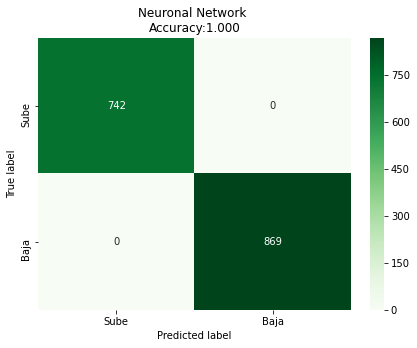

time: 243 ms


In [42]:

# Creates a confusion matrix
cm = confusion_matrix(prueba_train.Label, prueba_train.Prediction_dia) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['Sube','Baja'], 
                     columns = ['Sube','Baja'])
plt.figure(figsize=(7,5))
sns.heatmap(cm_df, annot=True, cmap="Greens", fmt='g')
plt.title('Neuronal Network \nAccuracy:{0:.3f}'.format(accuracy_score(prueba_train.Label, prueba_train.Prediction_dia)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [28]:
# evaluate the model
ypred_real = model_real.predict_proba(reshape_x_test_real)
len(ypred_real)

9443

time: 649 ms


In [43]:
testing_cp_real = testing_real.copy()
testing_cp_real['Prob'] = ypred_real
topics_real = testing_cp_real.loc[:,names]
testing_cp_real['topic_highest']=topics_real.idxmax(axis=1)
testing_cp_real['score_top'] = testing_cp_real.apply(lambda x: tops[str(x.Top)], axis=1)
testing_cp_real['score_topic'] = testing_cp_real.apply(lambda x: topics_acc[x.topic_highest], axis=1)
testing_cp_real['full_score'] = testing_cp_real['score_topic']* testing_cp_real['score_top'] 
testing_cp_real['score_dia'] = testing_cp_real['full_score'].groupby(testing_cp_real['Date']).transform('sum')
testing_cp_real['score_norm'] = testing_cp_real['full_score']/testing_cp_real['score_dia']
testing_cp_real['prob_norm'] = testing_cp_real['score_norm'] *  testing_cp_real['Prob']
testing_cp_real['prob_dia'] = testing_cp_real['prob_norm'].groupby(testing_cp_real['Date']).transform('sum')
testing_cp_real['Prediction_dia'] = 0
testing_cp_real.loc[testing_cp_real['prob_dia']> 0.5, 'Prediction_dia'] = 1
accuracy_score(testing_cp_real.Label, testing_cp_real.Prediction_dia)

0.5509901514349254

time: 1.04 s


In [44]:
prueba = testing_cp_real.drop_duplicates(subset = ['Date'])
prueba[['Date', 'Label','Prediction_dia']].to_csv('results_test.csv', index=False)

time: 26 ms


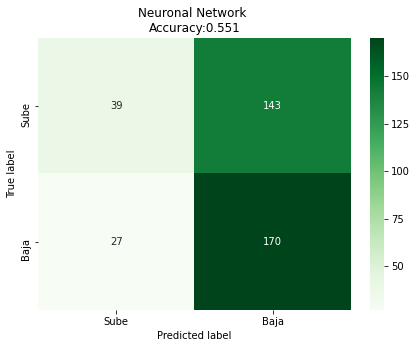

time: 475 ms


In [31]:

# Creates a confusion matrix
cm = confusion_matrix(prueba.Label, prueba.Prediction_dia) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['Sube','Baja'], 
                     columns = ['Sube','Baja'])
plt.figure(figsize=(7,5))
sns.heatmap(cm_df, annot=True, cmap="Greens", fmt='g')
plt.title('Neuronal Network \nAccuracy:{0:.3f}'.format(accuracy_score(prueba.Label, prueba.Prediction_dia)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
